In [1]:
import matplotlib.pyplot as plt
import torchvision
import torch

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from modular  import data_setup, engine
except:
    print("[INFO] Couldn't find modular scripts... downloading from GitHub.")
    !git clone https://github.com/daspartho/learn-pytorch
    !mv learn-pytorch/modular .
    !rm -rf learn-pytorch
    from modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find modular scripts... downloading from GitHub.
Cloning into 'learn-pytorch'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 109 (delta 47), reused 8 (delta 1), pack-reused 0
Receiving objects: 100% (109/109), 4.76 MiB | 11.81 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
!python modular/get_data.py

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping data...


In [4]:
from pathlib import Path

train_dir = "data/pizza_steak_sushi/train"
test_dir = "data/pizza_steak_sushi/test"

In [5]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [6]:
transforms = weights.transforms()
transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [7]:
train_dataloader, test_dataloader = data_setup.create_dataloaders(
    train_dir, 
    test_dir,
    transforms,
    32,
    )

In [8]:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [9]:
summary(model=model,
        input_size = (32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 1000]                --                        True
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        864                       True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        64                        True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --                

In [10]:
for param in model.features.parameters():
    param.requires_grad=False

In [11]:
output_shape = 3

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, 
              out_features=output_shape,
              bias=True)
).to(device)

In [12]:
summary(model=model,
        input_size = (32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --         

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
from timeit import default_timer as timer

EPOCHS=10

start = timer()

results = engine.train(model,
            train_dataloader,
            test_dataloader,
            loss_fn,
            optimizer,
            EPOCHS,
            device)

end = timer()
print(f"[INFO] total training time: {end-start:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 Train Loss: 1.022 Train Acc: 0.582 Test Loss: 0.811 Test Acc: 0.824
Epoch: 1 Train Loss: 0.918 Train Acc: 0.621 Test Loss: 0.666 Test Acc: 0.867
Epoch: 2 Train Loss: 0.748 Train Acc: 0.734 Test Loss: 0.543 Test Acc: 0.926
Epoch: 3 Train Loss: 0.658 Train Acc: 0.773 Test Loss: 0.488 Test Acc: 0.922
Epoch: 4 Train Loss: 0.615 Train Acc: 0.801 Test Loss: 0.435 Test Acc: 0.949
Epoch: 5 Train Loss: 0.533 Train Acc: 0.930 Test Loss: 0.405 Test Acc: 0.941
Epoch: 6 Train Loss: 0.596 Train Acc: 0.777 Test Loss: 0.391 Test Acc: 0.949
Epoch: 7 Train Loss: 0.499 Train Acc: 0.934 Test Loss: 0.353 Test Acc: 0.965
Epoch: 8 Train Loss: 0.500 Train Acc: 0.816 Test Loss: 0.336 Test Acc: 0.977
Epoch: 9 Train Loss: 0.433 Train Acc: 0.941 Test Loss: 0.307 Test Acc: 0.973
[INFO] total training time: 370.225 seconds


In [15]:
from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):

    train_loss = results["train loss"]
    train_acc = results["train acc"]
    test_loss = results["test loss"]
    test_acc = results["test acc"]

    epochs = range(len(train_loss))

    plt.figure(figsize=(15,7))

    plt.subplot(1,2,1)
    plt.plot(epochs, train_loss, label="train loss")
    plt.plot(epochs, test_loss, label="test loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, train_acc, label="train acc")
    plt.plot(epochs, test_acc, label="test acc")
    plt.title("Acc")
    plt.xlabel("Epochs")
    plt.legend()

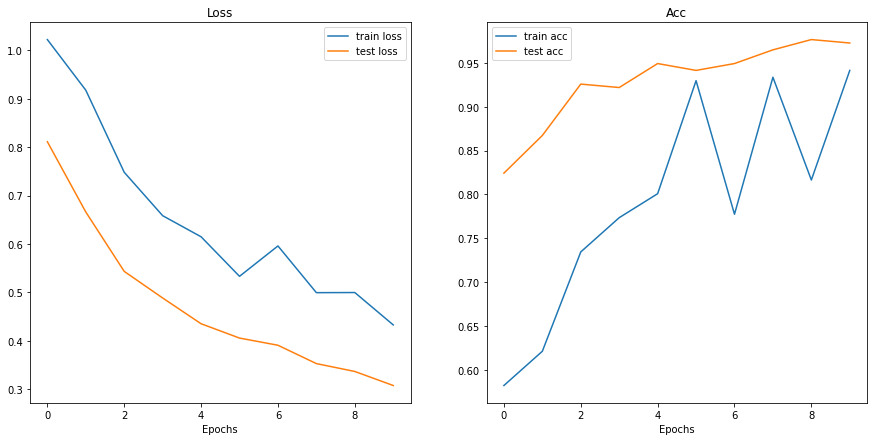

In [16]:
plot_loss_curves(results)

In [17]:
import requests
from PIL import Image

def pred(model: torch.nn.Module,
         url: str,
         class_names: List[str] = None,
         transform=None,
         device: torch.device = device):
    
    img_path = "test.jpeg"

    with open(img_path, "wb") as f:
            request = requests.get(url)
            f.write(request.content)
    
    img = Image.open(img_path)

    if transform:
        img = transform(img)

    model.to(device)
    model.eval()
    with torch.inference_mode():
        logits = model(img.unsqueeze(dim=0).to(device))
        pred_label = torch.argmax(torch.softmax(logits, dim=1), dim=1)
        
    plt.imshow(img.permute(1,2,0))
    if class_names:
        title = f"Pred: {class_names[pred_label.cpu()]}"
    else:
        title = f"Pred: {pred_label}"
    plt.title(title)
    plt.axis=(False)


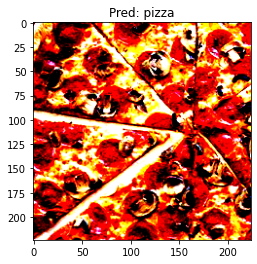

In [18]:
url = "https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse1.mm.bing.net%2Fth%3Fid%3DOIP.aPgW1MdLl_v98QCS2CITQAHaE7%26pid%3DApi&f=1&ipt=2000fed1cfe20048000afe8ab1416c046872f2c250c18fce786237eab2c27ad5&ipo=images"
class_names = ['pizza', 'steak', 'sushi']

pred(model,
     url,
     class_names,
     transforms,
     device)